# Questions per context
This script computes statistics for how many questions are asked for each context. The instruction to the annotators were just to ask questions on the given contexts, thus, each context could have any number of questions related to it.

In [1]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import itertools

In [2]:
df_train_eval = pd.read_pickle("../data_frames/parsed_answer_data/df_train_cleaned.pkl")
df_train = pd.read_pickle("../create_dataset/data/labeled_data_train.pkl")
df_eval = pd.read_pickle("../create_dataset/data/labeled_data_eval.pkl")
df_test = pd.read_pickle("../data_frames/parsed_answer_data/df_test.pkl")
df_train.head()


,index,choices,context,question,correct_answer,correct_answer_parsed,correct_answer_parsed_tok,correct_answer_parsed_stop,correct_answer_parsed_lemma,correct_answer_parsed_lemma_stop,...,paragraph_len,loc_frac,context_parsed,context_parsed_tok_lemma,context_parsed_tok_lemma_stop,context_parsed_tok_stop,context_parsed_tok,context_raw,context_id,relevant_sentence_ids
0,0.0,"[{'end': 224, 'extra': None, 'start': 175, 'te...",Visum för affärs- och konferensbesök\r\nOm du ...,Vad är ett visum?,ett tillstånd för att resa in och vara i ett land,ett tillstånd för att resa in och vara i ett land,"[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]",...,21.0,0.095238,"[visum för affärs- och konferensbesök, om du s...","[[visa, för, affär, och, konferensbesök], [om,...","[[visa, affär, konferensbesök], [om, skola, be...","[[visum, affärs-, konferensbesök], [om, ska, b...","[[visum, för, affärs-, och, konferensbesök], [...","[[Visum, för, affärs-, och, konferensbesök], [...",0.0,"(2, 7, 1, 6, 3)"
1,2.0,"[{'end': 1165, 'extra': None, 'start': 1154, '...",Utbytesdoktorander\r\nIntervju\r\nDu kommer at...,Hur länge gäller ett uppehållstillstånd för be...,ett år,ett år,"[ett, år]",[år],"[en, år]",[år],...,25.0,0.720000,"[utbytesdoktorander intervju, du kommer att få...","[[utbytesdoktorand, intervju], [du, komma, att...","[[utbytesdoktorand, intervju], [du, komma, få,...","[[utbytesdoktorander, intervju], [du, kommer, ...","[[utbytesdoktorander, intervju], [du, kommer, ...","[[Utbytesdoktorander, Intervju], [Du, kommer, ...",2.0,"(18, 19, 4, 5)"
2,3.0,"[{'end': 598, 'extra': None, 'start': 589, 'te...",Eget företag\r\nNär vi har tagit emot din ansö...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],...,21.0,0.380952,"[eget företag, när vi har tagit emot din ansök...","[[egen, företag], [när, vi, ha, ta, emot, du, ...","[[egen, företag], [när, ta, emot, ansökan], [o...","[[eget, företag], [när, tagit, emot, ansökan],...","[[eget, företag], [när, vi, har, tagit, emot, ...","[[Eget, företag], [När, vi, har, tagit, emot, ...",3.0,"(7, 10, 8)"
3,4.0,"[{'end': 1932, 'extra': None, 'start': 1924, '...",Flytta tillbaka till Sverige\r\nSå ansöker du\...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],...,21.0,0.380952,"[flytta tillbaka till sverige, så ansöker du d...","[[flytta, tillbaka, till, sverige], [så, ansök...","[[flytta, tillbaka, sverige], [så, ansöka, du,...","[[flytta, tillbaka, sverige], [så, ansöker, du...","[[flytta, tillbaka, till, sverige], [så, ansök...","[[Flytta, tillbaka, till, Sverige], [Så, ansök...",4.0,"(7, 20, 12, 10, 8)"
4,5.0,"[{'end': 1949, 'extra': None, 'start': 1939, '...",Uppehållstillstånd för medborgare i Schweiz\r\...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],...,19.0,0.842105,"[uppehållstillstånd för medborgare i schweiz, ...","[[uppehållstillstånd, för, medborgare, i, schw...","[[uppehållstillstånd, medborgare, schweiz], [s...","[[uppehållstillstånd, medborgare, schweiz], [s...","[[uppehållstillstånd, för, medborgare, i, schw...","[[Uppehållstillstånd, för, medborgare, i, Schw...",5.0,"(15, 18, 16)"


In [33]:
def plot_question_distribution(data):
    # plt.hist(data.values(), density=True, bins=10, color='g')
    min = np.min(np.array(list(data.values())))
    max = np.max(np.array(list(data.values())))
    print(min)
    print(max)
    bins = list(range(min, max+1))
    print(bins)
    plt.hist(data.values(), bins=bins, color='teal')
    plt.ylabel('Context texts')
    plt.xlabel('Number of Q/A pairs')
    plt.title('Number of Q/A pairs per context text')
    plt.show()

def plot_question_coubnt_vs_length(c_count_dict, c_length_dict):
    c_count = []
    c_length = []
    for key, val in c_count_dict.items():
        c_count.append(val)
        c_length.append(c_length_dict[key])
    # sort the two lists in ascending
    c_length, c_count = zip(*sorted(zip(c_length, c_count)))
    plt.plot(c_length, c_count, color='rebeccapurple')
    # plt.xlim(100, 1000)
    plt.ylabel('Number of Q/A pairs')
    plt.xlabel('Context text length')
    plt.title('Context text length vs number of Q/A pairs')
    plt.show()


In [34]:
def get_answer_statistics(df):
    answer_lengths = []
    for index, row in df.iterrows():
        ans = row['correct_answer_raw']
        answer_lengths.append(len(ans))
    return answer_lengths


In [35]:
def count_questions_per_answers(df):
    context_count_dict = {}
    context_length_dict = {}
    context_text_lengths = []
    for index, row in df.iterrows():
        context = row['context']
        context_parsed = row['context_raw']
        c = list(itertools.chain.from_iterable(context_parsed))
        if context in context_count_dict:
            context_count_dict[context] += 1
        else:
            context_length_dict[context] = len(c)
            context_count_dict[context] = 1
            context_text_lengths.append(len(c))
    print('Num contexts: ', len(context_count_dict))
    return context_count_dict, context_length_dict, context_text_lengths

c_count_dict, c_length_dict, context_text_lengths = count_questions_per_answers(df_train)
print('mean context text length: ', np.mean(context_text_lengths))
print('std: ', np.std(context_text_lengths))
ans_lengths = get_answer_statistics(df_train)
print('mean answer length: ', np.mean(ans_lengths))
print('std: ', np.std(ans_lengths))
plot_question_distribution(c_count_dict)
plot_question_coubnt_vs_length(c_count_dict, c_length_dict)

Num contexts:  453
mean context text length:  422.6534216335541
std:  421.3775699819313
mean answer length:  3.9880197322057787
std:  4.029034541221186
dict_values([2, 3, 2, 4, 4, 6, 4, 5, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 5, 2, 3, 2, 4, 2, 2, 4, 2, 4, 2, 2, 3, 2, 2, 2, 4, 2, 4, 3, 4, 2, 2, 4, 4, 4, 2, 2, 6, 4, 4, 2, 10, 2, 2, 6, 3, 4, 2, 3, 6, 5, 2, 4, 2, 6, 3, 4, 4, 6, 4, 3, 2, 4, 2, 2, 3, 2, 1, 1, 3, 1, 2, 3, 4, 4, 1, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, 3, 1, 2, 2, 1, 3, 1, 3, 3, 2, 1, 2, 1, 1, 3, 2, 4, 3, 1, 4, 2, 1, 1, 1, 1, 3, 2, 1, 3, 3, 2, 1, 1, 4, 3, 1, 4, 1, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 3, 5, 2, 2, 5, 3, 1, 2, 2, 2, 4, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 3, 1, 2, 1, 5, 2, 1, 2, 1, 1, 3, 1, 1, 2, 4, 1, 1, 2, 4, 3, 5, 2, 6, 1, 2, 2, 2, 1, 1, 3, 3, 1, 2, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 2, 2, 6, 1, 1, 1, 3, 2, 1, 4, 1, 5, 1, 3, 3, 2, 2, 2, 3, 1, 1, 3, 

TypeError: unsupported operand type(s) for +: 'dict_values' and 'int'

In [26]:
c_count_dict, c_length_dict, context_text_lengths = count_questions_per_answers(df_eval)
print('mean context text length: ', np.mean(context_text_lengths))
print('std: ', np.std(context_text_lengths))

ans_lengths = get_answer_statistics(df_eval)
print('mean answer length: ', np.mean(ans_lengths))
print('std: ', np.std(ans_lengths))

Num contexts:  104
mean context text length:  402.9326923076923
std:  343.26319416691695
mean answer length:  3.8857142857142857
std:  3.4887054561308535


In [27]:
c_count_dict, c_length_dict, context_text_lengths = count_questions_per_answers(df_test)
print('mean context text length: ', np.mean(context_text_lengths))
print('std: ', np.std(context_text_lengths))

ans_lengths = get_answer_statistics(df_test)
print('mean answer length: ', np.mean(ans_lengths))
print('std: ', np.std(ans_lengths))

Num contexts:  41
mean context text length:  367.1707317073171
std:  227.0704094563713
mean answer length:  4.4
std:  4.739725730461626


Num contexts:  557
mean context text length:  418.97127468581687
std:  408.00215514179587
mean answer length:  3.9968334388853703
std:  3.992153812520385
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


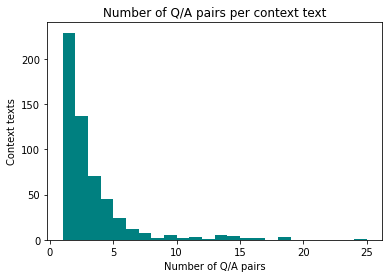

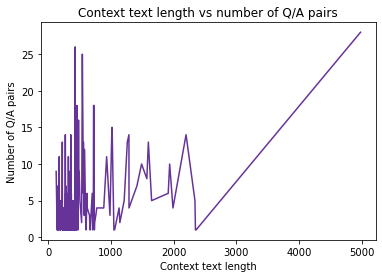

In [32]:
dict, l_dict, lengths = count_questions_per_answers(df_train_eval)
print('mean context text length: ', np.mean(lengths))
print('std: ', np.std(lengths))
ans_lengths = get_answer_statistics(df_train_eval)
print('mean answer length: ', np.mean(ans_lengths))
print('std: ', np.std(ans_lengths))
plot_question_distribution(dict)
plot_question_coubnt_vs_length(dict, l_dict)